This file contains an example of how to analyze the complex q parameter in the one photon case.
We'll consider ionization from the Radon's 6p_{3/2} hole and will investigate 6d and 8s resonances. We'll use data from three simulations: one for emission path, and two for absroption paths. The two absroption ones correspond to the regions of higher and lower energies respectively, those regions capture the resonances we're interested in. The two absorption simulations are matched with the emission in turn and then the results are concatenated.

In [1]:
# load data
import sys
import os 
import numpy as np
from matplotlib import pyplot as plt

# append the repo to the system path for convenient imports
repo_path = "D:\\photoionization_analysis"
sys.path.append(repo_path)

from fortran_output_analysis.constants_and_parameters import g_eV_per_Hartree

from fortran_output_analysis.onephoton.onephoton import OnePhoton
from fortran_output_analysis.onephoton.onephoton import Channels as Channels_1ph
import fortran_output_analysis.onephoton.onephoton_utilities as utils_1ph
import fortran_output_analysis.onephoton.onephoton_delays_and_phases as wigner
import fortran_output_analysis.onephoton.onephoton_asymmetry_parameters as asym_p_1ph
import fortran_output_analysis.complex_q_parameter as q_param

# we consider Radon data in this example
atom_name = "Radon"

# paths to the emission path, absorption path with higher energies and abosrption path with lower energies
# simulations
path_to_data_emi = "D:\\photoionization_analysis\\fortran_data\\paper_radon_emi\\" # path to emission data
path_to_data_abs = "D:\\photoionization_analysis\\fortran_data\\paper_radon_abs\\" # path to absorption with higher energies data
path_to_data_low_en = "D:\\photoionization_analysis\\fortran_data\\paper_radon_low_energies\\" # path to absorption with lower energies data

# energy of IR photon used in simulations in eV and in Hartree
g_omega_IR_eV = 1.55
g_omega_IR = (
    g_omega_IR_eV / g_eV_per_Hartree
) 

# we consider 6p_{3/2} Radon's hole in this example
hole_kappa_6p3half = -2
hole_n_6p3half = 6

# initialize OnePhoton objects for two absorption paths and emission path and load the hole
one_photon_emi = OnePhoton(atom_name) # object for emission path
one_photon_abs = OnePhoton(atom_name) # object for absorption path with higher energies
one_photon_low_en = OnePhoton(atom_name) # object for absorption path with lower energies
one_photon_emi.load_hole(hole_n_6p3half, hole_kappa_6p3half, path_to_data_emi)
one_photon_abs.load_hole(hole_n_6p3half, hole_kappa_6p3half, path_to_data_abs)
one_photon_low_en.load_hole(hole_n_6p3half, hole_kappa_6p3half, path_to_data_low_en)

# print possible ionization channels after one photon for Radon's 6p_{3/2}
labels_from_6p3half_1ph = one_photon_abs.get_channel_labels_for_hole(
    hole_n_6p3half, hole_kappa_6p3half
)
print(f"\nPossible one photon channels for Radon 6p_3/2: {labels_from_6p3half_1ph}\n")

# print binding energy of Radon's 6p_{3/2} in Hartree
channels_6p3half: Channels_1ph = one_photon_abs.get_channels_for_hole(
    hole_n_6p3half, hole_kappa_6p3half
)
hole_6p3half = channels_6p3half.get_hole_object()
print(f"\nBinding energy for Radon 6p_3/2 is {hole_6p3half.binding_energy} Hartree\n")

Z = 1 # charge of the remaining ion (since only one electron was ionized)


Possible one photon channels for Radon 6p_3/2: ['Radon 6p_{3/2} to s_{1/2}', 'Radon 6p_{3/2} to d_{3/2}', 'Radon 6p_{3/2} to d_{5/2}']


Binding energy for Radon 6p_3/2 is 0.395005703 Hartree



In [2]:
# match electron kinetic energies for two absorption simulations

ekin_eV, _, _ = utils_1ph.get_prepared_matrices(
    one_photon_emi,
    hole_n_6p3half, 
    hole_kappa_6p3half, 
    Z,
    g_omega_IR,
    one_photon_2=one_photon_abs,
    g_omega_IR_2=g_omega_IR,
    energies_mode="abs",
) # absorption path with higher energies
ekin_eV_low_en, _, _ = utils_1ph.get_prepared_matrices(
    one_photon_emi,
    hole_n_6p3half, 
    hole_kappa_6p3half, 
    Z,
    g_omega_IR,
    one_photon_2=one_photon_low_en,
    g_omega_IR_2=g_omega_IR,
    energies_mode="abs",
) # absorption path with lower energies

region_mask = np.logical_and(3.5 <= ekin_eV, ekin_eV <= 3.9)
region_mask_low_en = np.logical_and(3.3 <= ekin_eV_low_en, ekin_eV_low_en <= 3.5)

ekin_eV_concat = np.concatenate((ekin_eV_low_en[region_mask_low_en], ekin_eV[region_mask]))

In [3]:
abs_or_emi = "abs" # both resonances were in the absorption path

# Radon's 6d resonance parameters
E_res_6d = 2.095
width_res_6d = 0.149
q_6d = 2.94
# array with the scaled energies for 6d resonance
eps_6d = q_param.get_epsilon(
            ekin_eV_concat,
            abs_or_emi, 
            g_omega_IR_eV,
            E_res_6d,
            width_res_6d,
        )

# Radon's 8s resonance parameters
E_res_8s = 2.279
width_res_8s = 0.006
q_8s = 8.27
# array with the scaled energies for 8s resonance
eps_8s = q_param.get_epsilon(
            ekin_eV_concat,
            abs_or_emi, 
            g_omega_IR_eV,
            E_res_8s,
            width_res_8s,
        )

**Complex q parameter for the angularly integrated case**


At first, we'll check separate contirbutions from different ionization channels

In [4]:
# initialize arrays to store the results

# array to store integrated intensity
int_intens_arr = []

# arrays for A_0 and A_bg coefficients for each channel
coeffs_6d_arr = []
coeffs_8s_arr = []

# arrays for complex q parameters
q_complex_6d_arr = []
q_complex_8s_arr = []

# arrays to zeros of the real and imaginary parts of the phase expressed through complex q
im_zero_6d_arr = []
re_zero_1_6d_arr = []
re_zero_2_6d_arr = []
im_zero_8s_arr = []
re_zero_1_8s_arr = []
re_zero_2_8s_arr = []

# consider each ionization channel separately
for i in range(3):
    # compute two-photon matrix elements
    _, M_emi_matched, M_abs_matched = utils_1ph.get_prepared_matrices(
    one_photon_emi,
    hole_n_6p3half, 
    hole_kappa_6p3half, 
    Z,
    g_omega_IR,
    one_photon_2=one_photon_abs,
    g_omega_IR_2=g_omega_IR,
    energies_mode="abs",
    ) # absorption path with higher energies
    _, M_emi_matched_low_en, M_abs_matched_low_en = utils_1ph.get_prepared_matrices(
        one_photon_emi,
        hole_n_6p3half, 
        hole_kappa_6p3half, 
        Z,
        g_omega_IR,
        one_photon_2=one_photon_low_en,
        g_omega_IR_2=g_omega_IR,
        energies_mode="abs",
    ) # absorption path with lower energies

    # exclude all the channels expect for the current one
    for j in range(3):
        if i != j:
            M_emi_matched[i, :] = 0.0 + 1j * 0.0
            M_abs_matched[i, :] = 0.0 + 1j * 0.0
            M_emi_matched_low_en[i, :] = 0.0 + 1j * 0.0
            M_abs_matched_low_en[i, :] = 0.0 + 1j * 0.0

    # compute and concatenate integrated intensities for the two simulations
    int_intens = wigner.get_wigner_intensity(hole_kappa_6p3half, M_emi_matched, M_abs_matched)
    int_intens_low_en = wigner.get_wigner_intensity(hole_kappa_6p3half, M_emi_matched_low_en, M_abs_matched_low_en)
    int_intens_concat = np.concatenate((int_intens_low_en[region_mask_low_en], int_intens[region_mask]))
    int_intens_arr.append(int_intens_concat)

    # compute the results for 6d resonance
    # NOTE: the code is sensitive to the choice of eps_1 and eps_2
    A_bg_6d, A_0_6d = q_param.get_coefficients_for_integrated(
    abs_or_emi,
    eps_6d,
    int_intens_concat,
    q_6d,
    eps_1=-1.95,
    eps_2=0.0,
    )
    coeffs_6d_arr.append((A_bg_6d, A_0_6d))

    q_complex_6d = q_param.get_complex_q_integrated(A_bg_6d, A_0_6d, q_6d)
    q_complex_6d_arr.append(q_complex_6d)

    im_zero_6d, re_zero_1_6d, re_zero_2_6d = q_param.get_zeros(q_complex_6d)
    im_zero_6d_arr.append(im_zero_6d)
    re_zero_1_6d_arr.append(re_zero_1_6d)
    re_zero_2_6d_arr.append(re_zero_2_6d)

    # compute the results for 8s resonance
    # NOTE: the code is sensitive to the choice of eps_1 and eps_2
    A_bg_8s, A_0_8s = q_param.get_coefficients_for_integrated(
    abs_or_emi,
    eps_8s,
    int_intens_concat,
    q_8s,
    eps_1=-5.76,
    eps_2=0.0,
    )
    coeffs_8s_arr.append((A_bg_8s, A_0_8s))

    q_complex_8s = q_param.get_complex_q_integrated(A_bg_8s, A_0_8s, q_8s)
    q_complex_8s_arr.append(q_complex_8s)

    im_zero_8s, re_zero_1_8s, re_zero_2_8s = q_param.get_zeros(q_complex_8s)
    im_zero_8s_arr.append(im_zero_8s)
    re_zero_1_8s_arr.append(re_zero_1_8s)
    re_zero_2_8s_arr.append(re_zero_2_8s)
        

D:\photoionization_analysis\fortran_output_analysis\complex_q_parameter.py:258: RuntimeWarning: invalid value encountered in sqrt
  re_zero_1 = -np.real(q_complex) / 2 + np.sqrt(
D:\photoionization_analysis\fortran_output_analysis\complex_q_parameter.py:261: RuntimeWarning: invalid value encountered in sqrt
  re_zero_2 = -np.real(q_complex) / 2 - np.sqrt(


Text(0.5, 1.0, 'Contribution from different ionization channels')

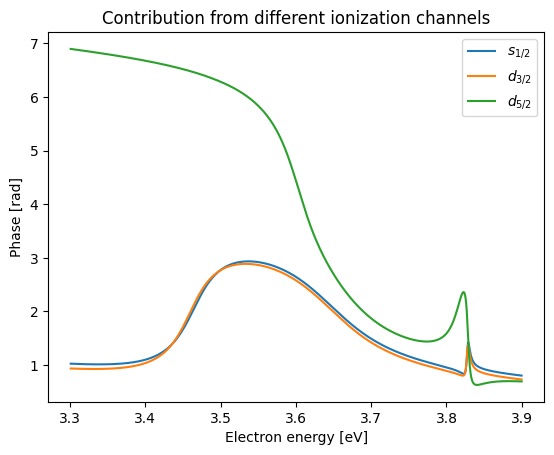

In [5]:
from fortran_output_analysis.common_utility import unwrap_phase_with_nans

# plot contribution from each separate channel
labels = ["$s_{1/2}$", "$d_{3/2}$", "$d_{5/2}$"]

for i in range(3):
    if i == 2:
        y = np.angle(int_intens_arr[i]) + 2 * np.pi
    else:
        y = np.angle(int_intens_arr[i])
    plt.plot(ekin_eV_concat, unwrap_phase_with_nans(y), label=labels[i])

plt.legend()
plt.xlabel("Electron energy [eV]")
plt.ylabel("Phase [rad]")
plt.title("Contribution from different ionization channels")

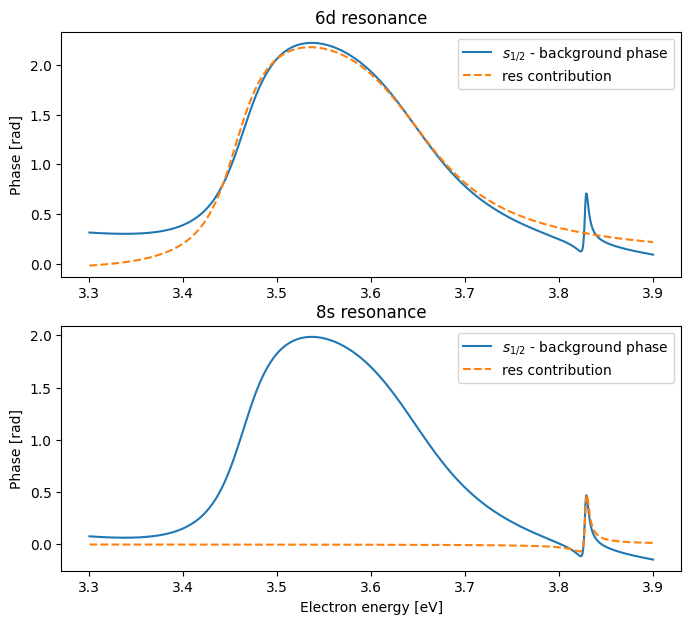

In [6]:
# analyze contribution of s_{1/2}
i = 0 # index of the s_{1/2} channel

# exctract corresponding complex q for both resonances
q_complex_6d = q_complex_6d_arr[i]
q_complex_8s = q_complex_8s_arr[i]

# compare contribution from the resonance formula and real contribution from the channel
# contribution from the resonance formula, apply conjugate since the resonance was in the absorption path
res_contribution_intens_6d = np.conjugate((eps_6d + q_complex_6d) / (eps_6d + 1 * 1j))
res_contribution_phase_6d = np.angle(res_contribution_intens_6d)
res_contribution_intens_8s = np.conjugate((eps_8s + q_complex_8s) / (eps_8s + 1 * 1j))
res_contribution_phase_8s = np.angle(res_contribution_intens_8s)

# contribution from the channel, have to substract background phase from the channek, conjugate again
A_bg_6d, A_0_6d = coeffs_6d_arr[i]
A_bg_8s, A_0_8s = coeffs_8s_arr[i]
background_contr_6d = q_param.get_background_contribution_integrated(abs_or_emi, A_bg_6d, A_0_6d)
background_contr_8s = q_param.get_background_contribution_integrated(abs_or_emi, A_bg_8s, A_0_8s)
background_phase_6d = np.angle(background_contr_6d)
background_phase_8s = np.angle(background_contr_8s)
channel_without_background_6d = np.angle(int_intens_arr[i]) - background_phase_6d
channel_without_background_8s = np.angle(int_intens_arr[i]) - background_phase_8s

plt.figure(figsize=(8, 7))
plt.subplot(2, 1, 1)
plt.plot(ekin_eV_concat, unwrap_phase_with_nans(channel_without_background_6d), label="$s_{1/2}$ - background phase")
plt.plot(ekin_eV_concat, unwrap_phase_with_nans(res_contribution_phase_6d), "--", label="res contribution")
plt.title("6d resonance")
plt.ylabel("Phase [rad]")
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(ekin_eV_concat, unwrap_phase_with_nans(channel_without_background_8s), label="$s_{1/2}$ - background phase")
plt.plot(ekin_eV_concat, unwrap_phase_with_nans(res_contribution_phase_8s), "--", label="res contribution")
plt.title("8s resonance")
plt.ylabel("Phase [rad]")
plt.xlabel("Electron energy [eV]")
plt.legend()

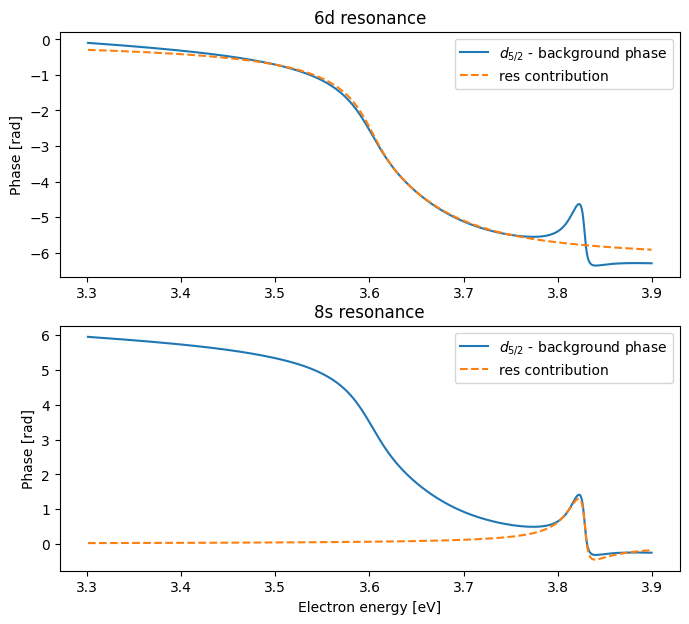

In [7]:
# analyze contribution of d_{5/2}
i = 2 # index of the d_{5/2} channel

# exctract corresponding complex q for both resonances
q_complex_6d = q_complex_6d_arr[i]
q_complex_8s = q_complex_8s_arr[i]

# compare contribution from the resonance formula and real contribution from the channel
# contribution from the resonance formula, apply conjugate since the resonance was in the absorption path
res_contribution_intens_6d = np.conjugate((eps_6d + q_complex_6d) / (eps_6d + 1 * 1j))
res_contribution_phase_6d = np.angle(res_contribution_intens_6d)
res_contribution_intens_8s = np.conjugate((eps_8s + q_complex_8s) / (eps_8s + 1 * 1j))
res_contribution_phase_8s = np.angle(res_contribution_intens_8s)

# contribution from the channel, have to substract background phase from the channek, conjugate again
A_bg_6d, A_0_6d = coeffs_6d_arr[i]
A_bg_8s, A_0_8s = coeffs_8s_arr[i]
background_contr_6d = q_param.get_background_contribution_integrated(abs_or_emi, A_bg_6d, A_0_6d)
background_contr_8s = q_param.get_background_contribution_integrated(abs_or_emi, A_bg_8s, A_0_8s)
background_phase_6d = np.angle(background_contr_6d)
background_phase_8s = np.angle(background_contr_8s)
channel_without_background_6d = np.angle(int_intens_arr[i]) - background_phase_6d
channel_without_background_8s = np.angle(int_intens_arr[i]) - background_phase_8s

plt.figure(figsize=(8, 7))
plt.subplot(2, 1, 1)
plt.plot(ekin_eV_concat, unwrap_phase_with_nans(channel_without_background_6d), label="$d_{5/2}$ - background phase")
plt.plot(ekin_eV_concat, unwrap_phase_with_nans(res_contribution_phase_6d), "--", label="res contribution")
plt.title("6d resonance")
plt.ylabel("Phase [rad]")
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(ekin_eV_concat, unwrap_phase_with_nans(channel_without_background_8s) + 2 * np.pi, label="$d_{5/2}$ - background phase")
plt.plot(ekin_eV_concat, unwrap_phase_with_nans(res_contribution_phase_8s), "--", label="res contribution")
plt.title("8s resonance")
plt.ylabel("Phase [rad]")
plt.xlabel("Electron energy [eV]")
plt.legend()

Zeros for $s_{1/2}$, 6d: Im -4.281433212114927; Re -0.17305722264366064, -2.359870327918097
Zeros for $s_{1/2}$, 8s: Im -1.147349233135082; Re nan, nan


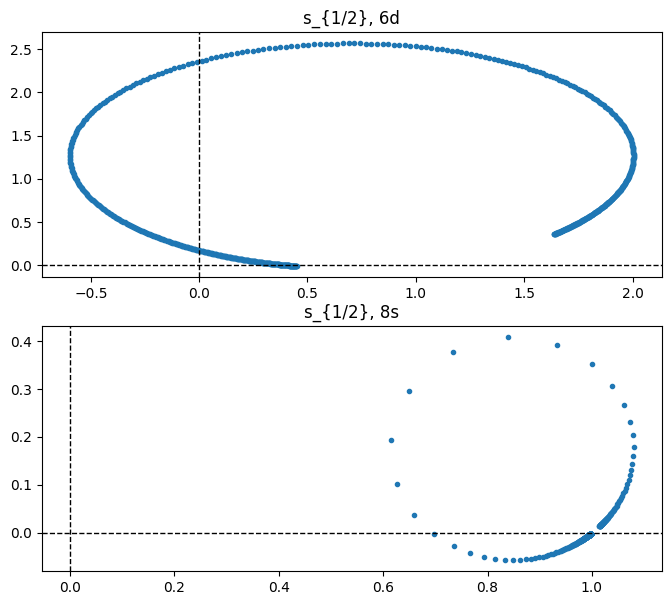

In [8]:
# analyze behaviour and zeros of complex q for s_{1/2}
i = 0 # index of the s_{1/2} channel

# exctract corresponding complex q for both resonances
q_complex_6d = q_complex_6d_arr[i]
q_complex_8s = q_complex_8s_arr[i]

# apply conjugate since the resonance was in the absorption path
q_plot_values_6d = np.conjugate((eps_6d + q_complex_6d) / (eps_6d + 1 * 1j))
q_plot_values_8s = np.conjugate((eps_8s + q_complex_8s) / (eps_8s + 1 * 1j))

plt.figure(figsize=(8, 7))
plt.subplot(2, 1, 1)
plt.plot(np.real(q_plot_values_6d), np.imag(q_plot_values_6d), "o", markersize=3)
plt.axhline(y=0.0, color='black', linestyle='--', linewidth=1)
plt.axvline(x=0.0, color='black', linestyle='--', linewidth=1)
plt.title("s_{1/2}, 6d")
print(f"Zeros for {labels[i]}, 6d: Im {im_zero_6d_arr[i]}; Re {re_zero_1_6d_arr[i]}, {re_zero_2_6d_arr[i]}")


plt.subplot(2, 1, 2)
plt.plot(np.real(q_plot_values_8s), np.imag(q_plot_values_8s), "o", markersize=3)
plt.axhline(y=0.0, color='black', linestyle='--', linewidth=1)
plt.axvline(x=0.0, color='black', linestyle='--', linewidth=1)
plt.title("s_{1/2}, 8s")
print(f"Zeros for {labels[i]}, 8s: Im {im_zero_8s_arr[i]}; Re {re_zero_1_8s_arr[i]}, {re_zero_2_8s_arr[i]}")


Zeros for $d_{5/2}$, 6d: Im -0.42150512201614376; Re 0.35997569618470165, -0.9212659789805266
Zeros for $d_{5/2}$, 8s: Im 0.6444339103280419; Re nan, nan


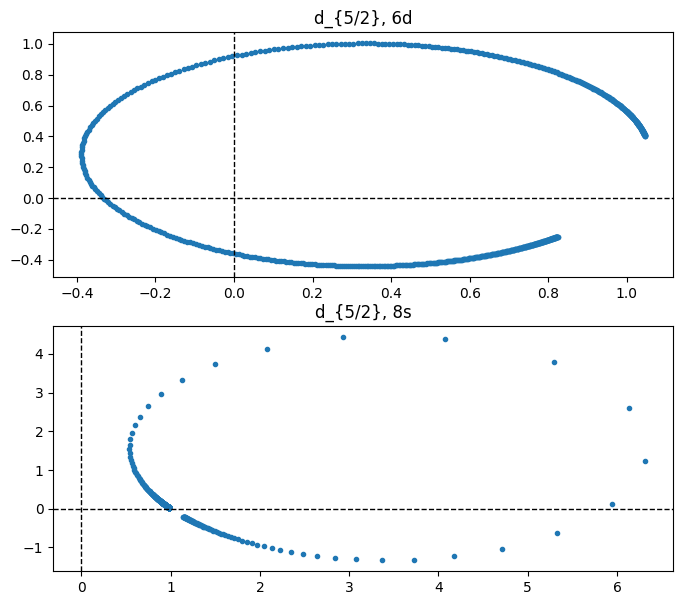

In [9]:
# analyze behaviour and zeros of complex q for d_{5/2}
i = 2 # index of the d_{5/2} channel

# exctract corresponding complex q for both resonances
q_complex_6d = q_complex_6d_arr[i]
q_complex_8s = q_complex_8s_arr[i]

# apply conjugate since the resonance was in the absorption path
q_plot_values_6d = np.conjugate((eps_6d + q_complex_6d) / (eps_6d + 1 * 1j))
q_plot_values_8s = np.conjugate((eps_8s + q_complex_8s) / (eps_8s + 1 * 1j))

plt.figure(figsize=(8, 7))
plt.subplot(2, 1, 1)
plt.plot(np.real(q_plot_values_6d), np.imag(q_plot_values_6d), "o", markersize=3)
plt.axhline(y=0.0, color='black', linestyle='--', linewidth=1)
plt.axvline(x=0.0, color='black', linestyle='--', linewidth=1)
plt.title("d_{5/2}, 6d")
print(f"Zeros for {labels[i]}, 6d: Im {im_zero_6d_arr[i]}; Re {re_zero_1_6d_arr[i]}, {re_zero_2_6d_arr[i]}")


plt.subplot(2, 1, 2)
plt.plot(np.real(q_plot_values_8s), np.imag(q_plot_values_8s), "o", markersize=3)
plt.axhline(y=0.0, color='black', linestyle='--', linewidth=1)
plt.axvline(x=0.0, color='black', linestyle='--', linewidth=1)
plt.title("d_{5/2}, 8s")
print(f"Zeros for {labels[i]}, 8s: Im {im_zero_8s_arr[i]}; Re {re_zero_1_8s_arr[i]}, {re_zero_2_8s_arr[i]}")

Now, we check the complex q behavior for the total (all channels) integrated wigner phase

Text(0.5, 1.0, 'Total integrated wigner phase')

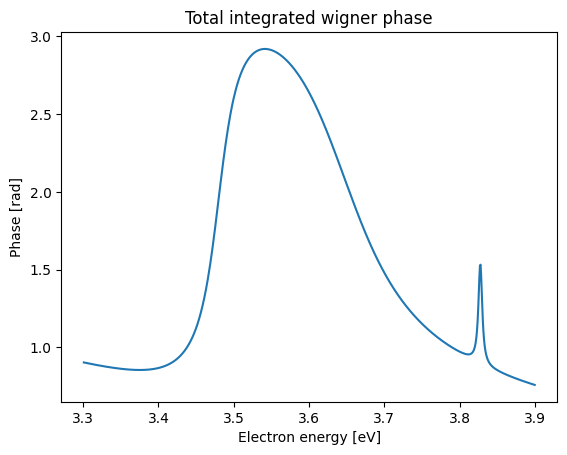

In [10]:
# compute total integrated wigner phase
_, phase_int_wigner = wigner.get_integrated_wigner_phase(one_photon_emi, 
                                                                 hole_n_6p3half, 
                                                                 hole_kappa_6p3half, 
                                                                 Z, 
                                                                 g_omega_IR,
                                                                 one_photon_2=one_photon_abs,
                                                                 g_omega_IR_2=g_omega_IR,
																 energies_mode="abs")

_, phase_int_wigner_low_en= wigner.get_integrated_wigner_phase(one_photon_emi, 
                                                                 hole_n_6p3half, 
                                                                 hole_kappa_6p3half, 
                                                                 Z, 
                                                                 g_omega_IR,
                                                                 one_photon_2=one_photon_low_en,
                                                                 g_omega_IR_2=g_omega_IR,
																 energies_mode="abs"
																 )

phase_int_wigner_concat = np.concatenate((phase_int_wigner_low_en[region_mask_low_en], 
								   phase_int_wigner[region_mask]))

plt.plot(ekin_eV_concat, phase_int_wigner_concat)
plt.xlabel("Electron energy [eV]")
plt.ylabel("Phase [rad]")
plt.title("Total integrated wigner phase")

In [11]:
# perform the same analysis for the total integrated wigner phase

# compute two-photon matrix elements
_, M_emi_matched, M_abs_matched = utils_1ph.get_prepared_matrices(
one_photon_emi,
hole_n_6p3half, 
hole_kappa_6p3half, 
Z,
g_omega_IR,
one_photon_2=one_photon_abs,
g_omega_IR_2=g_omega_IR,
energies_mode="abs",
) # absorption path with higher energies
_, M_emi_matched_low_en, M_abs_matched_low_en = utils_1ph.get_prepared_matrices(
    one_photon_emi,
    hole_n_6p3half, 
    hole_kappa_6p3half, 
    Z,
    g_omega_IR,
    one_photon_2=one_photon_low_en,
    g_omega_IR_2=g_omega_IR,
    energies_mode="abs",
) # absorption path with lower energies


# compute and concatenate integrated intensities for the two absorption simulations
int_intens = wigner.get_wigner_intensity(hole_kappa_6p3half, M_emi_matched, M_abs_matched)
int_intens_low_en = wigner.get_wigner_intensity(hole_kappa_6p3half, M_emi_matched_low_en, M_abs_matched_low_en)
int_intens_concat = np.concatenate((int_intens_low_en[region_mask_low_en], int_intens[region_mask]))

# compute the results for 6d resonance
# NOTE: the code is sensitive to the choice of eps_1 and eps_2
A_bg_6d, A_0_6d = q_param.get_coefficients_for_integrated(
abs_or_emi,
eps_6d,
int_intens_concat,
q_6d,
eps_1=-1.95,
eps_2=0.0,
)

q_complex_6d = q_param.get_complex_q_integrated(A_bg_6d, A_0_6d, q_6d)

im_zero_6d, re_zero_1_6d, re_zero_2_6d = q_param.get_zeros(q_complex_6d)

# compute the results for 8s resonance
# NOTE: the code is sensitive to the choice of eps_1 and eps_2
A_bg_8s, A_0_8s = q_param.get_coefficients_for_integrated(
abs_or_emi,
eps_8s,
int_intens_concat,
q_8s,
eps_1=-5.76,
eps_2=0.0,
)

q_complex_8s = q_param.get_complex_q_integrated(A_bg_8s, A_0_8s, q_8s)

im_zero_8s, re_zero_1_8s, re_zero_2_8s = q_param.get_zeros(q_complex_8s)
        

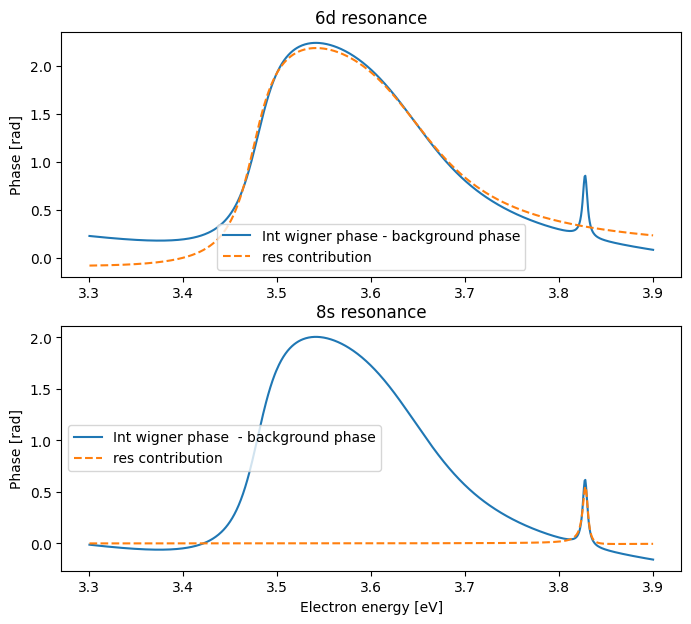

In [12]:
# compare contribution from the resonance formula and real wigner phase
# contribution from the resonance formula, apply conjugate since the resonance was in the absorption path
res_contribution_intens_6d = np.conjugate((eps_6d + q_complex_6d) / (eps_6d + 1 * 1j))
res_contribution_phase_6d = np.angle(res_contribution_intens_6d)
res_contribution_intens_8s = np.conjugate((eps_8s + q_complex_8s) / (eps_8s + 1 * 1j))
res_contribution_phase_8s = np.angle(res_contribution_intens_8s)

# contribution from the channel, have to substract background phase from the channek, conjugate again
background_contr_6d = q_param.get_background_contribution_integrated(abs_or_emi, A_bg_6d, A_0_6d)
background_contr_8s = q_param.get_background_contribution_integrated(abs_or_emi, A_bg_8s, A_0_8s)
background_phase_6d = np.angle(background_contr_6d)
background_phase_8s = np.angle(background_contr_8s)
wigner_phase_without_background_6d = phase_int_wigner_concat - background_phase_6d
wigner_phase_without_background_8s = phase_int_wigner_concat - background_phase_8s

plt.figure(figsize=(8, 7))
plt.subplot(2, 1, 1)
plt.plot(ekin_eV_concat, unwrap_phase_with_nans(wigner_phase_without_background_6d), label="Int wigner phase - background phase")
plt.plot(ekin_eV_concat, unwrap_phase_with_nans(res_contribution_phase_6d), "--", label="res contribution")
plt.title("6d resonance")
plt.ylabel("Phase [rad]")
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(ekin_eV_concat, unwrap_phase_with_nans(wigner_phase_without_background_8s), label="Int wigner phase  - background phase")
plt.plot(ekin_eV_concat, unwrap_phase_with_nans(res_contribution_phase_8s), "--", label="res contribution")
plt.title("8s resonance")
plt.ylabel("Phase [rad]")
plt.xlabel("Electron energy [eV]")
plt.legend()

Zeros for total_wigner, 6d: Im -3.270632199253072; Re -0.14210595431783923, -2.1358389153318105
Zeros for total_wigner, 8s: Im 5.3328641940203845; Re nan, nan


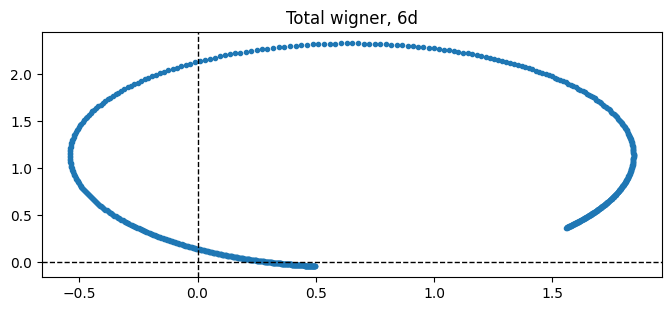

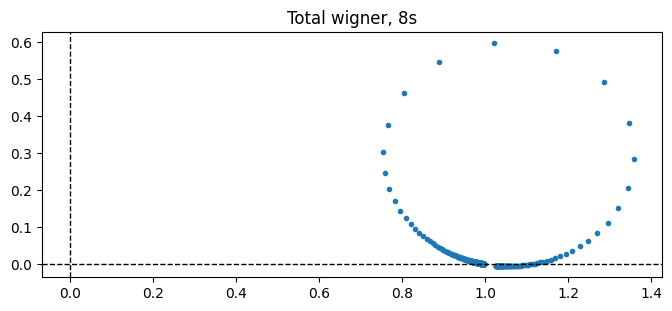

In [13]:
# apply conjugate since the resonance was in the absorption path
q_plot_values_6d = np.conjugate((eps_6d + q_complex_6d) / (eps_6d + 1 * 1j))
q_plot_values_8s = np.conjugate((eps_8s + q_complex_8s) / (eps_8s + 1 * 1j))

plt.figure(figsize=(8, 7))
plt.subplot(2, 1, 1)
plt.plot(np.real(q_plot_values_6d), np.imag(q_plot_values_6d), "o", markersize=3)
plt.axhline(y=0.0, color='black', linestyle='--', linewidth=1)
plt.axvline(x=0.0, color='black', linestyle='--', linewidth=1)
plt.title("Total wigner, 6d")
print(f"Zeros for total_wigner, 6d: Im {im_zero_6d}; Re {re_zero_1_6d}, {re_zero_2_6d}")


plt.figure(figsize=(8, 7))
plt.subplot(2, 1, 2)
plt.plot(np.real(q_plot_values_8s), np.imag(q_plot_values_8s), "o", markersize=3)
plt.axhline(y=0.0, color='black', linestyle='--', linewidth=1)
plt.axvline(x=0.0, color='black', linestyle='--', linewidth=1)
plt.title("Total wigner, 8s")
print(f"Zeros for total_wigner, 8s: Im {im_zero_8s}; Re {re_zero_1_8s}, {re_zero_2_8s}")

**Complex q parameter for the angularly resolved case**

Now, we consider how complex q parameter explains angularly dependent phase.

In [14]:
angles = [0, 30, 60] # angles to consider

Text(0.5, 1.0, 'Angularly resolved wigner phase')

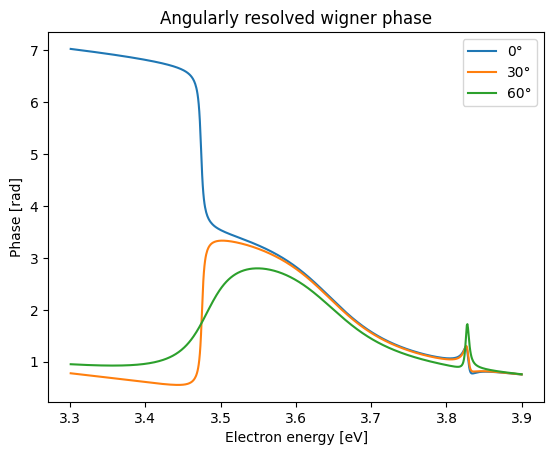

In [15]:
# check how angularly dependent wigner phase looks like
_, phase_ang_wigner = wigner.get_wigner_phase(
                                            one_photon_emi, 
                                            hole_n_6p3half, 
                                            hole_kappa_6p3half, 
                                            Z, 
                                            g_omega_IR,
                                            angles,
                                            one_photon_2=one_photon_abs,
                                            g_omega_IR_2=g_omega_IR,
                                            energies_mode="abs"
                                            )

_, phase_ang_wigner_low_en = wigner.get_wigner_phase(
                                            one_photon_emi, 
                                            hole_n_6p3half, 
                                            hole_kappa_6p3half, 
                                            Z, 
                                            g_omega_IR,
                                            angles,
                                            one_photon_2=one_photon_low_en,
                                            g_omega_IR_2=g_omega_IR,
                                            energies_mode="abs"
                                           )

# adding two pi changes nothing, but makes plots nicer
phase_ang_wigner_low_en[0, :] += 2 * np.pi 

# concatenate wigner phases for two absorption paths
phase_ang_wigner_concat = np.concatenate((phase_ang_wigner_low_en[:, region_mask_low_en], 
								   phase_ang_wigner[:, region_mask]), axis=1)

for i, angle in enumerate(angles):
    plt.plot(ekin_eV_concat, phase_ang_wigner_concat[i], label=f"{angle}°")

plt.legend()
plt.xlabel("Electron energy [eV]")
plt.ylabel("Phase [rad]")
plt.title("Angularly resolved wigner phase")

In [16]:
# compute coefficients for complex q in the angularly resolved case

# compute two-photon matrix elements
_, M_emi_matched, M_abs_matched = utils_1ph.get_prepared_matrices(
one_photon_emi,
hole_n_6p3half, 
hole_kappa_6p3half, 
Z,
g_omega_IR,
one_photon_2=one_photon_abs,
g_omega_IR_2=g_omega_IR,
energies_mode="abs",
) # absorption path with higher energies
_, M_emi_matched_low_en, M_abs_matched_low_en = utils_1ph.get_prepared_matrices(
    one_photon_emi,
    hole_n_6p3half, 
    hole_kappa_6p3half, 
    Z,
    g_omega_IR,
    one_photon_2=one_photon_low_en,
    g_omega_IR_2=g_omega_IR,
    energies_mode="abs",
) # absorption path with lower energies


# compute and concatenate integrated intensities for the two absorption simulations
int_intens = wigner.get_wigner_intensity(hole_kappa_6p3half, M_emi_matched, M_abs_matched)
int_intens_low_en = wigner.get_wigner_intensity(hole_kappa_6p3half, M_emi_matched_low_en, M_abs_matched_low_en)
int_intens_concat = np.concatenate((int_intens_low_en[region_mask_low_en], int_intens[region_mask]))

# compute asymmetry parameters for the two absorption simulations and concatenate them
b2, _ = asym_p_1ph.one_photon_asymmetry_parameter(
    hole_kappa_6p3half, 
    M_emi_matched, 
    M_abs_matched, 
    "cross"
)
b2_low_en, _ = asym_p_1ph.one_photon_asymmetry_parameter(
    hole_kappa_6p3half, 
    M_emi_matched_low_en, 
    M_abs_matched_low_en, 
    "cross"
)
b2_concat = np.concatenate((b2_low_en[region_mask_low_en], b2[region_mask]))


# q complex coefficients for the integrated intensity
# NOTE: the code is sensitive to the choice of eps_1 and eps_2
A_bg_int_6d, A_0_int_6d = q_param.get_coefficients_for_integrated(
                                abs_or_emi, 
                                eps_6d,
                                int_intens_concat,
                                q_6d,
                                eps_1=-2.28,
                                eps_2=0.0,
                            )
A_bg_int_8s, A_0_int_8s = q_param.get_coefficients_for_integrated(
                                abs_or_emi, 
                                eps_8s,
                                int_intens_concat,
                                q_8s,
                                eps_1=-5.76,
                                eps_2=0.0,
                            )

# q complex coefficients for the second order beta parameter
A_bg_b2_6d, A_0_b2_6d = q_param.get_coefficients_for_beta_param(
                                abs_or_emi, 
                                eps_6d,
                                int_intens_concat,
                                b2_concat,
                                q_6d,
                                eps_1=-2.28,
                                eps_2=0.0,
                            )
A_bg_b2_8s, A_0_b2_8s = q_param.get_coefficients_for_beta_param(
                                abs_or_emi, 
                                eps_8s,
                                int_intens_concat,
                                b2_concat,
                                q_8s,
                                eps_1=-5.76,
                                eps_2=0.0,
                            )

# q complex coefficients for the fourth order beta parameter will be zero
# since the fourth order beta is zero in the one photon case
A_bg_b4_6d, A_0_b4_6d = 0, 0
A_bg_b4_8s, A_0_b4_8s = 0, 0

In [17]:
# compute complex q parameters and their zeros for different angles using the coefficients above
q_complex_6d_arr = []
q_complex_8s_arr = []
im_zero_6d_arr = []
im_zero_8s_arr = []
re_zero_1_6d_arr = []
re_zero_1_8s_arr = []
re_zero_2_6d_arr = []
re_zero_2_8s_arr = []

for angle in angles:
    q_complex_6d = q_param.get_complex_q_angular(
        angle,
        A_bg_int_6d, 
        A_0_int_6d,
        A_bg_b2_6d, 
        A_0_b2_6d,
        A_bg_b4_6d, 
        A_0_b4_6d,
        q_6d
    )
    q_complex_6d_arr.append(q_complex_6d)

    # zeros of the real and imaginary part for 6d resonance
    im_zero_6d, re_zero_1_6d, re_zero_2_6d = q_param.get_zeros(q_complex_6d)
    im_zero_6d_arr.append(im_zero_6d)
    re_zero_1_6d_arr.append(re_zero_1_6d)
    re_zero_2_6d_arr.append(re_zero_2_6d)

    q_complex_8s = q_param.get_complex_q_angular(
        angle,
        A_bg_int_8s, 
        A_0_int_8s,
        A_bg_b2_8s, 
        A_0_b2_8s,
        A_bg_b4_8s, 
        A_0_b4_8s,
        q_8s
    )
    q_complex_8s_arr.append(q_complex_8s)
    
    # zeros of the real and imaginary part for 8s resonance
    im_zero_8s, re_zero_1_8s, re_zero_2_8s = q_param.get_zeros(q_complex_8s)
    im_zero_8s_arr.append(im_zero_8s)
    re_zero_1_8s_arr.append(re_zero_1_8s)
    re_zero_2_8s_arr.append(re_zero_2_8s)
 

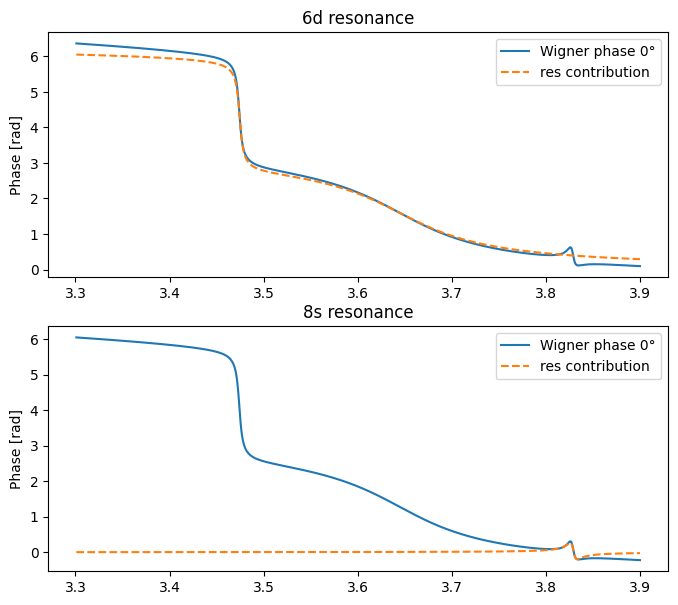

In [18]:
# analyze resonance contribtuion to the phase at 0 angle
i = 0 # index corresponding to zero angle
angle = angles[i]

# exctract corresponding complex q for both resonances
q_complex_6d = q_complex_6d_arr[i]
q_complex_8s = q_complex_8s_arr[i]

# compare contribution from the resonance formula and real phase
# contribution from the resonance formula, apply conjugate since the resonance was in the absorption path
res_contribution_intens_6d = np.conjugate((eps_6d + q_complex_6d) / (eps_6d + 1 * 1j))
res_contribution_phase_6d = np.angle(res_contribution_intens_6d)
res_contribution_phase_6d += 2 * np.pi
res_contribution_intens_8s = np.conjugate((eps_8s + q_complex_8s) / (eps_8s + 1 * 1j))
res_contribution_phase_8s = np.angle(res_contribution_intens_8s)

# real phase, have to substract background phase, conjugate again
background_contr_6d = q_param.get_background_contribution_angular(
                                                            angle,
                                                            abs_or_emi,
                                                            A_bg_int_6d, 
                                                            A_0_int_6d,
                                                            A_bg_b2_6d, 
                                                            A_0_b2_6d,
                                                            A_bg_b4_6d, 
                                                            A_0_b4_6d,                                                            
                                                            )
background_contr_8s = q_param.get_background_contribution_angular(
                                                            angle,
                                                            abs_or_emi,
                                                            A_bg_int_8s, 
                                                            A_0_int_8s,
                                                            A_bg_b2_8s, 
                                                            A_0_b2_8s,
                                                            A_bg_b4_8s, 
                                                            A_0_b4_8s,                                                            
                                                            )
background_phase_6d = np.angle(background_contr_6d)
background_phase_8s = np.angle(background_contr_8s)
wigner_phase_without_background_6d = phase_ang_wigner_concat[i, :] - background_phase_6d
wigner_phase_without_background_8s = phase_ang_wigner_concat[i, :]  - background_phase_8s

plt.figure(figsize=(8, 7))
plt.subplot(2, 1, 1)
plt.plot(ekin_eV_concat, unwrap_phase_with_nans(wigner_phase_without_background_6d), label=f"Wigner phase {angles[i]}°")
plt.plot(ekin_eV_concat, unwrap_phase_with_nans(res_contribution_phase_6d), "--", label="res contribution")
plt.title("6d resonance")
plt.ylabel("Phase [rad]")
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(ekin_eV_concat, unwrap_phase_with_nans(wigner_phase_without_background_8s), label=f"Wigner phase {angles[i]}°")
plt.plot(ekin_eV_concat, unwrap_phase_with_nans(res_contribution_phase_8s), "--", label="res contribution")
plt.title("8s resonance")
plt.ylabel("Phase [rad]")
plt.legend()


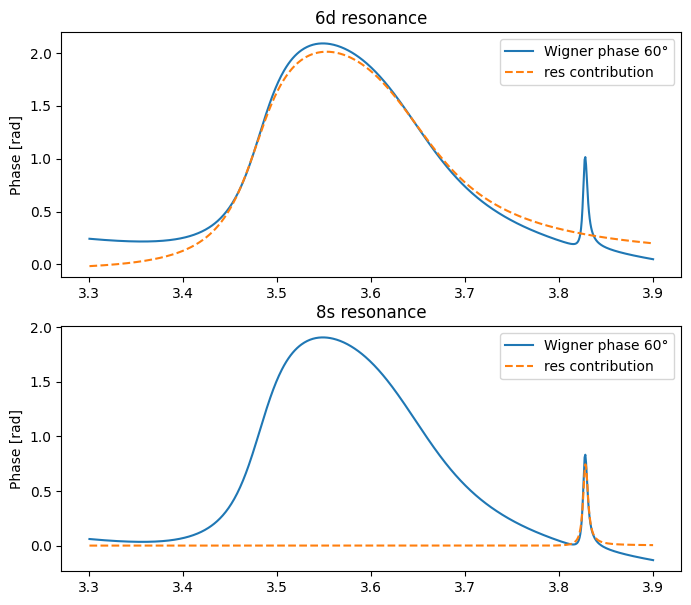

In [19]:
# analyze resonance contribtuion to the phase at 60 angle
i = 2 # index corresponding to 60 angle
angle = angles[i]

# exctract corresponding complex q for both resonances
q_complex_6d = q_complex_6d_arr[i]
q_complex_8s = q_complex_8s_arr[i]

# compare contribution from the resonance formula and real phase
# contribution from the resonance formula, apply conjugate since the resonance was in the absorption path
res_contribution_intens_6d = np.conjugate((eps_6d + q_complex_6d) / (eps_6d + 1 * 1j))
res_contribution_phase_6d = np.angle(res_contribution_intens_6d)
res_contribution_intens_8s = np.conjugate((eps_8s + q_complex_8s) / (eps_8s + 1 * 1j))
res_contribution_phase_8s = np.angle(res_contribution_intens_8s)

# real phase, have to substract background phase, conjugate again
background_contr_6d = q_param.get_background_contribution_angular(
                                                            angle,
                                                            abs_or_emi,
                                                            A_bg_int_6d, 
                                                            A_0_int_6d,
                                                            A_bg_b2_6d, 
                                                            A_0_b2_6d,
                                                            A_bg_b4_6d, 
                                                            A_0_b4_6d,                                                            
                                                            )
background_contr_8s = q_param.get_background_contribution_angular(
                                                            angle,
                                                            abs_or_emi,
                                                            A_bg_int_8s, 
                                                            A_0_int_8s,
                                                            A_bg_b2_8s, 
                                                            A_0_b2_8s,
                                                            A_bg_b4_8s, 
                                                            A_0_b4_8s,                                                            
                                                            )
background_phase_6d = np.angle(background_contr_6d)
background_phase_8s = np.angle(background_contr_8s)
wigner_phase_without_background_6d = phase_ang_wigner_concat[i, :] - background_phase_6d
wigner_phase_without_background_8s = phase_ang_wigner_concat[i, :]  - background_phase_8s

plt.figure(figsize=(8, 7))
plt.subplot(2, 1, 1)
plt.plot(ekin_eV_concat, unwrap_phase_with_nans(wigner_phase_without_background_6d), label=f"Wigner phase {angles[i]}°")
plt.plot(ekin_eV_concat, unwrap_phase_with_nans(res_contribution_phase_6d), "--", label="res contribution")
plt.title("6d resonance")
plt.ylabel("Phase [rad]")
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(ekin_eV_concat, unwrap_phase_with_nans(wigner_phase_without_background_8s), label=f"Wigner phase {angles[i]}°")
plt.plot(ekin_eV_concat, unwrap_phase_with_nans(res_contribution_phase_8s), "--", label="res contribution")
plt.title("8s resonance")
plt.ylabel("Phase [rad]")
plt.legend()

Zeros for angle 0°, 6d: Im -2.201873433109519; Re 0.01739211532774121, -2.3076370556688603
Zeros for angle 0°, 8s: Im 0.14518204907312907; Re nan, nan


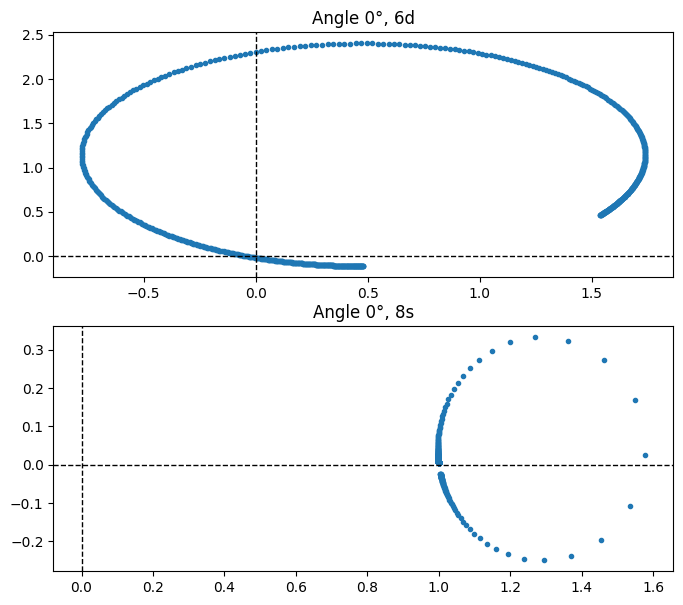

In [20]:
# analyze behaviour and zeros of complex q for 0 angle
i = 0 # index corresponding to 0 angle

# exctract corresponding complex q for both resonances
q_complex_6d = q_complex_6d_arr[i]
q_complex_8s = q_complex_8s_arr[i]

# apply conjugate since the resonance was in the absorption path
q_plot_values_6d = np.conjugate((eps_6d + q_complex_6d) / (eps_6d + 1 * 1j))
q_plot_values_8s = np.conjugate((eps_8s + q_complex_8s) / (eps_8s + 1 * 1j))

plt.figure(figsize=(8, 7))
plt.subplot(2, 1, 1)
plt.plot(np.real(q_plot_values_6d), np.imag(q_plot_values_6d), "o", markersize=3)
plt.axhline(y=0.0, color='black', linestyle='--', linewidth=1)
plt.axvline(x=0.0, color='black', linestyle='--', linewidth=1)
plt.title(f"Angle {angles[i]}°, 6d")
print(f"Zeros for angle {angles[i]}°, 6d: Im {im_zero_6d_arr[i]}; Re {re_zero_1_6d_arr[i]}, {re_zero_2_6d_arr[i]}")


plt.subplot(2, 1, 2)
plt.plot(np.real(q_plot_values_8s), np.imag(q_plot_values_8s), "o", markersize=3)
plt.axhline(y=0.0, color='black', linestyle='--', linewidth=1)
plt.axvline(x=0.0, color='black', linestyle='--', linewidth=1)
plt.title(f"Angle {angles[i]}°, 8s")
print(f"Zeros for angle {angles[i]}°, 8s: Im {im_zero_8s_arr[i]}; Re {re_zero_1_8s_arr[i]}, {re_zero_2_8s_arr[i]}")



Zeros for angle 60°, 6d: Im -4.272613616735236; Re -0.2408809811538275, -1.9868666479054105
Zeros for angle 60°, 8s: Im -11.62924583530877; Re nan, nan


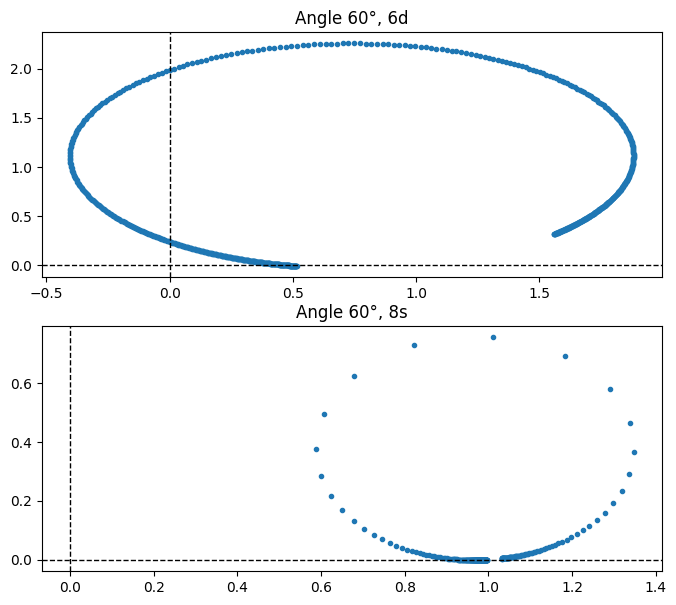

In [21]:
# analyze behaviour and zeros of complex q for 60 angle
i = 2 # index corresponding to 60 angle

# exctract corresponding complex q for both resonances
q_complex_6d = q_complex_6d_arr[i]
q_complex_8s = q_complex_8s_arr[i]

# apply conjugate since the resonance was in the absorption path
q_plot_values_6d = np.conjugate((eps_6d + q_complex_6d) / (eps_6d + 1 * 1j))
q_plot_values_8s = np.conjugate((eps_8s + q_complex_8s) / (eps_8s + 1 * 1j))

plt.figure(figsize=(8, 7))
plt.subplot(2, 1, 1)
plt.plot(np.real(q_plot_values_6d), np.imag(q_plot_values_6d), "o", markersize=3)
plt.axhline(y=0.0, color='black', linestyle='--', linewidth=1)
plt.axvline(x=0.0, color='black', linestyle='--', linewidth=1)
plt.title(f"Angle {angles[i]}°, 6d")
print(f"Zeros for angle {angles[i]}°, 6d: Im {im_zero_6d_arr[i]}; Re {re_zero_1_6d_arr[i]}, {re_zero_2_6d_arr[i]}")


plt.subplot(2, 1, 2)
plt.plot(np.real(q_plot_values_8s), np.imag(q_plot_values_8s), "o", markersize=3)
plt.axhline(y=0.0, color='black', linestyle='--', linewidth=1)
plt.axvline(x=0.0, color='black', linestyle='--', linewidth=1)
plt.title(f"Angle {angles[i]}°, 8s")
print(f"Zeros for angle {angles[i]}°, 8s: Im {im_zero_8s_arr[i]}; Re {re_zero_1_8s_arr[i]}, {re_zero_2_8s_arr[i]}")



Finally, we're going to find critical angles where the phase switches from 2pi to pi jump in the Radon's 6d and 8s resonances

In [22]:
# compute coefficients for complex q in the angularly resolved case

# compute two-photon matrix elements
_, M_emi_matched, M_abs_matched = utils_1ph.get_prepared_matrices(
one_photon_emi,
hole_n_6p3half, 
hole_kappa_6p3half, 
Z,
g_omega_IR,
one_photon_2=one_photon_abs,
g_omega_IR_2=g_omega_IR,
energies_mode="abs",
) # absorption path with higher energies
_, M_emi_matched_low_en, M_abs_matched_low_en = utils_1ph.get_prepared_matrices(
    one_photon_emi,
    hole_n_6p3half, 
    hole_kappa_6p3half, 
    Z,
    g_omega_IR,
    one_photon_2=one_photon_low_en,
    g_omega_IR_2=g_omega_IR,
    energies_mode="abs",
) # absorption path with lower energies


# compute and concatenate integrated intensities for the two absorption simulations
int_intens = wigner.get_wigner_intensity(hole_kappa_6p3half, M_emi_matched, M_abs_matched)
int_intens_low_en = wigner.get_wigner_intensity(hole_kappa_6p3half, M_emi_matched_low_en, M_abs_matched_low_en)
int_intens_concat = np.concatenate((int_intens_low_en[region_mask_low_en], int_intens[region_mask]))

# compute asymmetry parameters for the two absorption simulations and concatenate them
b2, _ = asym_p_1ph.one_photon_asymmetry_parameter(
    hole_kappa_6p3half, 
    M_emi_matched, 
    M_abs_matched, 
    "cross"
)
b2_low_en, _ = asym_p_1ph.one_photon_asymmetry_parameter(
    hole_kappa_6p3half, 
    M_emi_matched_low_en, 
    M_abs_matched_low_en, 
    "cross"
)
b2_concat = np.concatenate((b2_low_en[region_mask_low_en], b2[region_mask]))


# q complex coefficients for the integrated intensity
# NOTE: the code is sensitive to the choice of eps_1 and eps_2
A_bg_int_6d, A_0_int_6d = q_param.get_coefficients_for_integrated(
                                abs_or_emi, 
                                eps_6d,
                                int_intens_concat,
                                q_6d,
                                eps_1=-2.28,
                                eps_2=0.0,
                            )
A_bg_int_8s, A_0_int_8s = q_param.get_coefficients_for_integrated(
                                abs_or_emi, 
                                eps_8s,
                                int_intens_concat,
                                q_8s,
                                eps_1=-0.01,
                                eps_2=0.0,
                            )

# q complex coefficients for the second order beta parameter
A_bg_b2_6d, A_0_b2_6d = q_param.get_coefficients_for_beta_param(
                                abs_or_emi, 
                                eps_6d,
                                int_intens_concat,
                                b2_concat,
                                q_6d,
                                eps_1=-2.28,
                                eps_2=0.0,
                            )
A_bg_b2_8s, A_0_b2_8s = q_param.get_coefficients_for_beta_param(
                                abs_or_emi, 
                                eps_8s,
                                int_intens_concat,
                                b2_concat,
                                q_8s,
                                eps_1=-0.01,
                                eps_2=0.0,
                            )

# q complex coefficients for the fourth order beta parameter will be zero
# since the fourth order beta is zero in the one photon case
A_bg_b4_6d, A_0_b4_6d = 0, 0
A_bg_b4_8s, A_0_b4_8s = 0, 0

At first, we investigate a region of smaller angles

In [23]:
angles = np.arange(70)

Text(0.5, 1.0, 'Angularly resolved wigner phase')

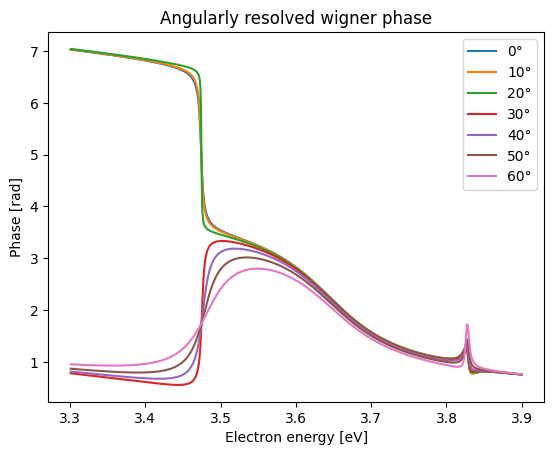

In [24]:
# check how angularly dependent wigner phase looks like
_, phase_ang_wigner = wigner.get_wigner_phase(
                                            one_photon_emi, 
                                            hole_n_6p3half, 
                                            hole_kappa_6p3half, 
                                            Z, 
                                            g_omega_IR,
                                            angles,
                                            one_photon_2=one_photon_abs,
                                            g_omega_IR_2=g_omega_IR,
                                            energies_mode="abs"
                                            )

_, phase_ang_wigner_low_en = wigner.get_wigner_phase(
                                            one_photon_emi, 
                                            hole_n_6p3half, 
                                            hole_kappa_6p3half, 
                                            Z, 
                                            g_omega_IR,
                                            angles,
                                            one_photon_2=one_photon_low_en,
                                            g_omega_IR_2=g_omega_IR,
                                            energies_mode="abs"
                                           )

# adding two pi changes nothing, but makes plots nicer
phase_ang_wigner_low_en[[0, 10, 20], :] += 2 * np.pi 

# concatenate wigner phases for two absorption paths
phase_ang_wigner_concat = np.concatenate((phase_ang_wigner_low_en[:, region_mask_low_en], 
								   phase_ang_wigner[:, region_mask]), axis=1)

for i in range(0, len(angles), 10):
    plt.plot(ekin_eV_concat, phase_ang_wigner_concat[i], label=f"{angles[i]}°")

plt.legend()
plt.xlabel("Electron energy [eV]")
plt.ylabel("Phase [rad]")
plt.title("Angularly resolved wigner phase")

In [25]:
# compute complex q parameters and their zeros for different angles using the coefficients above
q_complex_6d_arr = []
q_complex_8s_arr = []
im_zero_6d_arr = []
im_zero_8s_arr = []
re_zero_1_6d_arr = []
re_zero_1_8s_arr = []
re_zero_2_6d_arr = []
re_zero_2_8s_arr = []

for angle in angles:
    q_complex_6d = q_param.get_complex_q_angular(
        angle,
        A_bg_int_6d, 
        A_0_int_6d,
        A_bg_b2_6d, 
        A_0_b2_6d,
        A_bg_b4_6d, 
        A_0_b4_6d,
        q_6d
    )
    q_complex_6d_arr.append(q_complex_6d)

    # zeros of the real and imaginary part for 6d resonance
    im_zero_6d, re_zero_1_6d, re_zero_2_6d = q_param.get_zeros(q_complex_6d)
    im_zero_6d_arr.append(im_zero_6d)
    re_zero_1_6d_arr.append(re_zero_1_6d)
    re_zero_2_6d_arr.append(re_zero_2_6d)

    q_complex_8s = q_param.get_complex_q_angular(
        angle,
        A_bg_int_8s, 
        A_0_int_8s,
        A_bg_b2_8s, 
        A_0_b2_8s,
        A_bg_b4_8s, 
        A_0_b4_8s,
        q_8s
    )
    q_complex_8s_arr.append(q_complex_8s)
    
    # zeros of the real and imaginary part for 8s resonance
    im_zero_8s, re_zero_1_8s, re_zero_2_8s = q_param.get_zeros(q_complex_8s)
    im_zero_8s_arr.append(im_zero_8s)
    re_zero_1_8s_arr.append(re_zero_1_8s)
    re_zero_2_8s_arr.append(re_zero_2_8s)
 

Text(0.5, 1.0, 'Region of smaller angles, 6d')

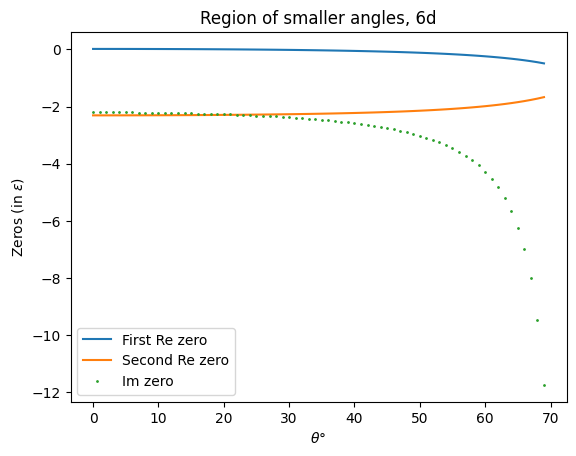

In [26]:
plt.plot(angles, re_zero_1_6d_arr, label="First Re zero")
plt.plot(angles, re_zero_2_6d_arr, label="Second Re zero")
plt.plot(angles, im_zero_6d_arr, "o", markersize=1, label="Im zero")
plt.legend()
plt.xlabel(f"$\\theta$°")
plt.ylabel("Zeros (in $\\epsilon$)")
plt.title("Region of smaller angles, 6d")

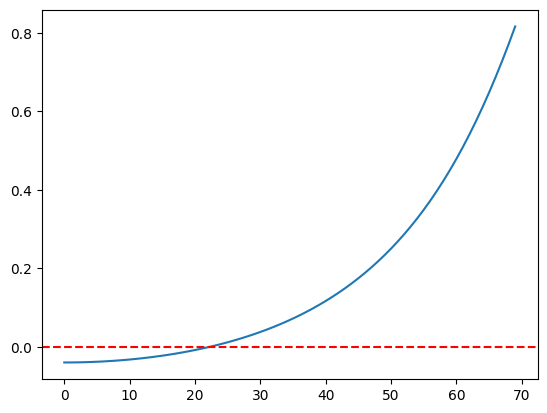

In [ ]:
# imaginary part of complex q is zero at critical angle
plt.plot(angles, np.imag(q_complex_6d_arr))
plt.axhline(y=0, color='r', linestyle='--')

Text(0.5, 1.0, 'Region of smaller angles, 8s')

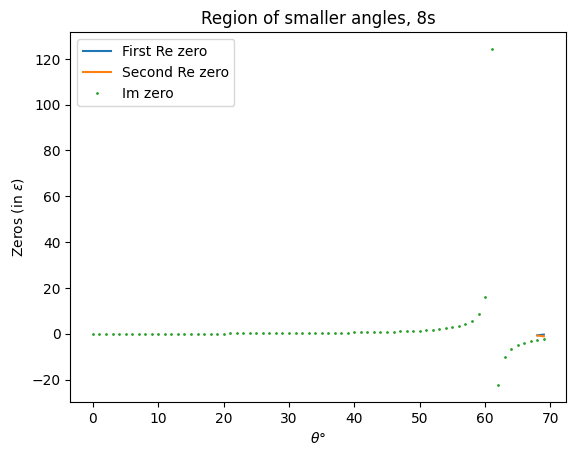

In [28]:
plt.plot(angles, re_zero_1_8s_arr, label="First Re zero")
plt.plot(angles, re_zero_2_8s_arr, label="Second Re zero")
plt.plot(angles, im_zero_8s_arr, "o", markersize=1, label="Im zero")
plt.legend()
plt.xlabel(f"$\\theta$°")
plt.ylabel("Zeros (in $\\epsilon$)")
plt.title("Region of smaller angles, 8s")

Then, we investigate a region of larger angles

In [29]:
angles = np.arange(70, 91, 0.1)

Text(0.5, 1.0, 'Angularly resolved wigner phase')

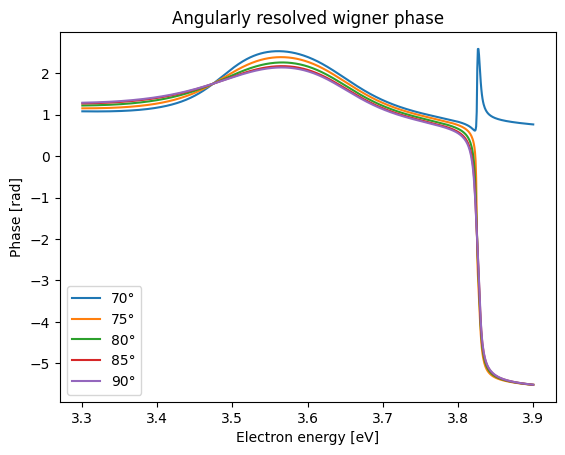

In [30]:
# check how angularly dependent wigner phase looks like
_, phase_ang_wigner = wigner.get_wigner_phase(
                                            one_photon_emi, 
                                            hole_n_6p3half, 
                                            hole_kappa_6p3half, 
                                            Z, 
                                            g_omega_IR,
                                            angles,
                                            one_photon_2=one_photon_abs,
                                            g_omega_IR_2=g_omega_IR,
                                            energies_mode="abs"
                                            )

_, phase_ang_wigner_low_en = wigner.get_wigner_phase(
                                            one_photon_emi, 
                                            hole_n_6p3half, 
                                            hole_kappa_6p3half, 
                                            Z, 
                                            g_omega_IR,
                                            angles,
                                            one_photon_2=one_photon_low_en,
                                            g_omega_IR_2=g_omega_IR,
                                            energies_mode="abs"
                                           )

# concatenate wigner phases for two absorption paths
phase_ang_wigner_concat = np.concatenate((phase_ang_wigner_low_en[:, region_mask_low_en], 
								   phase_ang_wigner[:, region_mask]), axis=1)

# adding two pi changes nothing, but makes plots nicer

# region_mask_plot = ekin_eV_concat >= 3.827
# for i in [50, 100, 150]:
#     phase_ang_wigner_concat[i, region_mask_plot] += 2 * np.pi 

for i in range(0, len(angles), 50):
    plt.plot(ekin_eV_concat, phase_ang_wigner_concat[i], label=f"{round(angles[i])}°")

plt.legend()
plt.xlabel("Electron energy [eV]")
plt.ylabel("Phase [rad]")
plt.title("Angularly resolved wigner phase")

In [31]:
# compute complex q parameters and their zeros for different angles using the coefficients above
q_complex_6d_arr = []
q_complex_8s_arr = []
im_zero_6d_arr = []
im_zero_8s_arr = []
re_zero_1_6d_arr = []
re_zero_1_8s_arr = []
re_zero_2_6d_arr = []
re_zero_2_8s_arr = []

for angle in angles:
    q_complex_6d = q_param.get_complex_q_angular(
        angle,
        A_bg_int_6d, 
        A_0_int_6d,
        A_bg_b2_6d, 
        A_0_b2_6d,
        A_bg_b4_6d, 
        A_0_b4_6d,
        q_6d
    )
    q_complex_6d_arr.append(q_complex_6d)

    # zeros of the real and imaginary part for 6d resonance
    im_zero_6d, re_zero_1_6d, re_zero_2_6d = q_param.get_zeros(q_complex_6d)
    im_zero_6d_arr.append(im_zero_6d)
    re_zero_1_6d_arr.append(re_zero_1_6d)
    re_zero_2_6d_arr.append(re_zero_2_6d)

    q_complex_8s = q_param.get_complex_q_angular(
        angle,
        A_bg_int_8s, 
        A_0_int_8s,
        A_bg_b2_8s, 
        A_0_b2_8s,
        A_bg_b4_8s, 
        A_0_b4_8s,
        q_8s
    )
    q_complex_8s_arr.append(q_complex_8s)
    
    # zeros of the real and imaginary part for 8s resonance
    im_zero_8s, re_zero_1_8s, re_zero_2_8s = q_param.get_zeros(q_complex_8s)
    im_zero_8s_arr.append(im_zero_8s)
    re_zero_1_8s_arr.append(re_zero_1_8s)
    re_zero_2_8s_arr.append(re_zero_2_8s)
 

Text(0.5, 1.0, 'Region of larger angles, 6d')

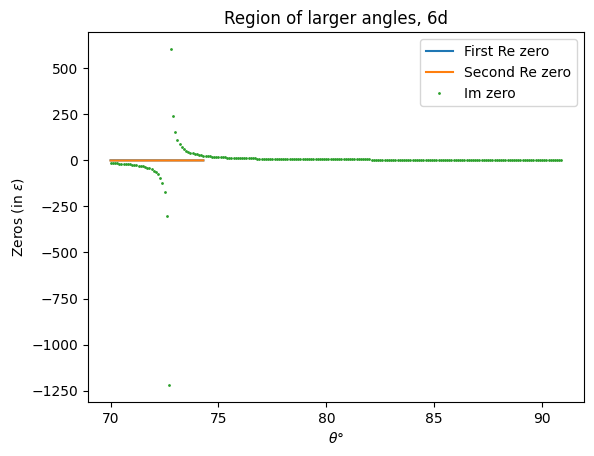

In [32]:
plt.plot(angles, re_zero_1_6d_arr, label="First Re zero")
plt.plot(angles, re_zero_2_6d_arr, label="Second Re zero")
plt.plot(angles, im_zero_6d_arr, "o", markersize=1, label="Im zero")
plt.legend()
plt.xlabel(f"$\\theta$°")
plt.ylabel("Zeros (in $\\epsilon$)")
plt.title("Region of larger angles, 6d")

Text(0.5, 1.0, 'Region of larger angles, 8s')

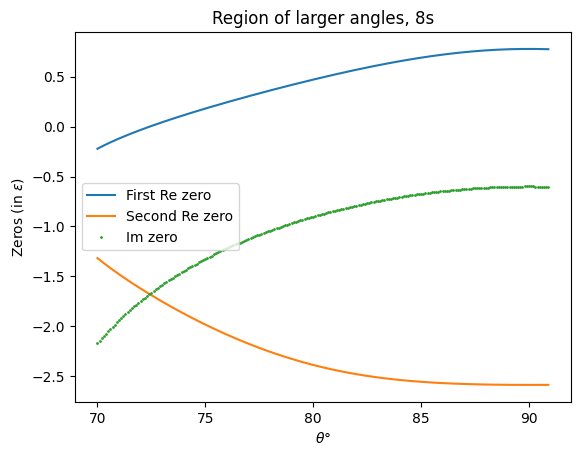

In [33]:
plt.plot(angles, re_zero_1_8s_arr, label="First Re zero")
plt.plot(angles, re_zero_2_8s_arr, label="Second Re zero")
plt.plot(angles, im_zero_8s_arr, "o", markersize=1, label="Im zero")
plt.legend()
plt.xlabel(f"$\\theta$°")
plt.ylabel("Zeros (in $\\epsilon$)")
plt.title("Region of larger angles, 8s")

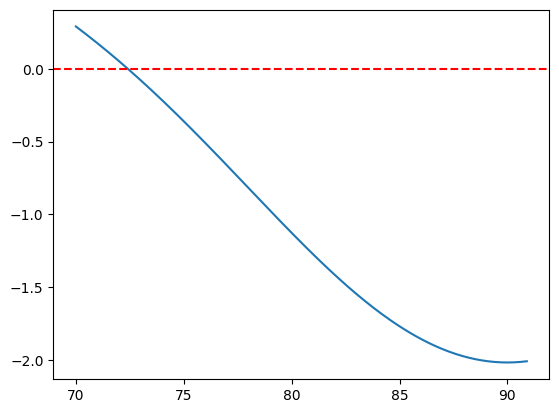

In [ ]:
# imaginary part of complex q is zero at critical angle
plt.plot(angles, np.imag(q_complex_8s_arr))
plt.axhline(y=0, color='r', linestyle='--')